In [40]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

import pytensor.printing
from pytensor.graph.basic import ancestors
from pytensor.d3viz import d3viz
import matplotlib.pyplot as plt
from pytensor.printing import pydotprint

In [41]:
az.style.use("arviz-whitegrid")
plt.rc('figure', dpi=450)

Beta distribution parameters: alpha = 15.3098, beta = 7.2241


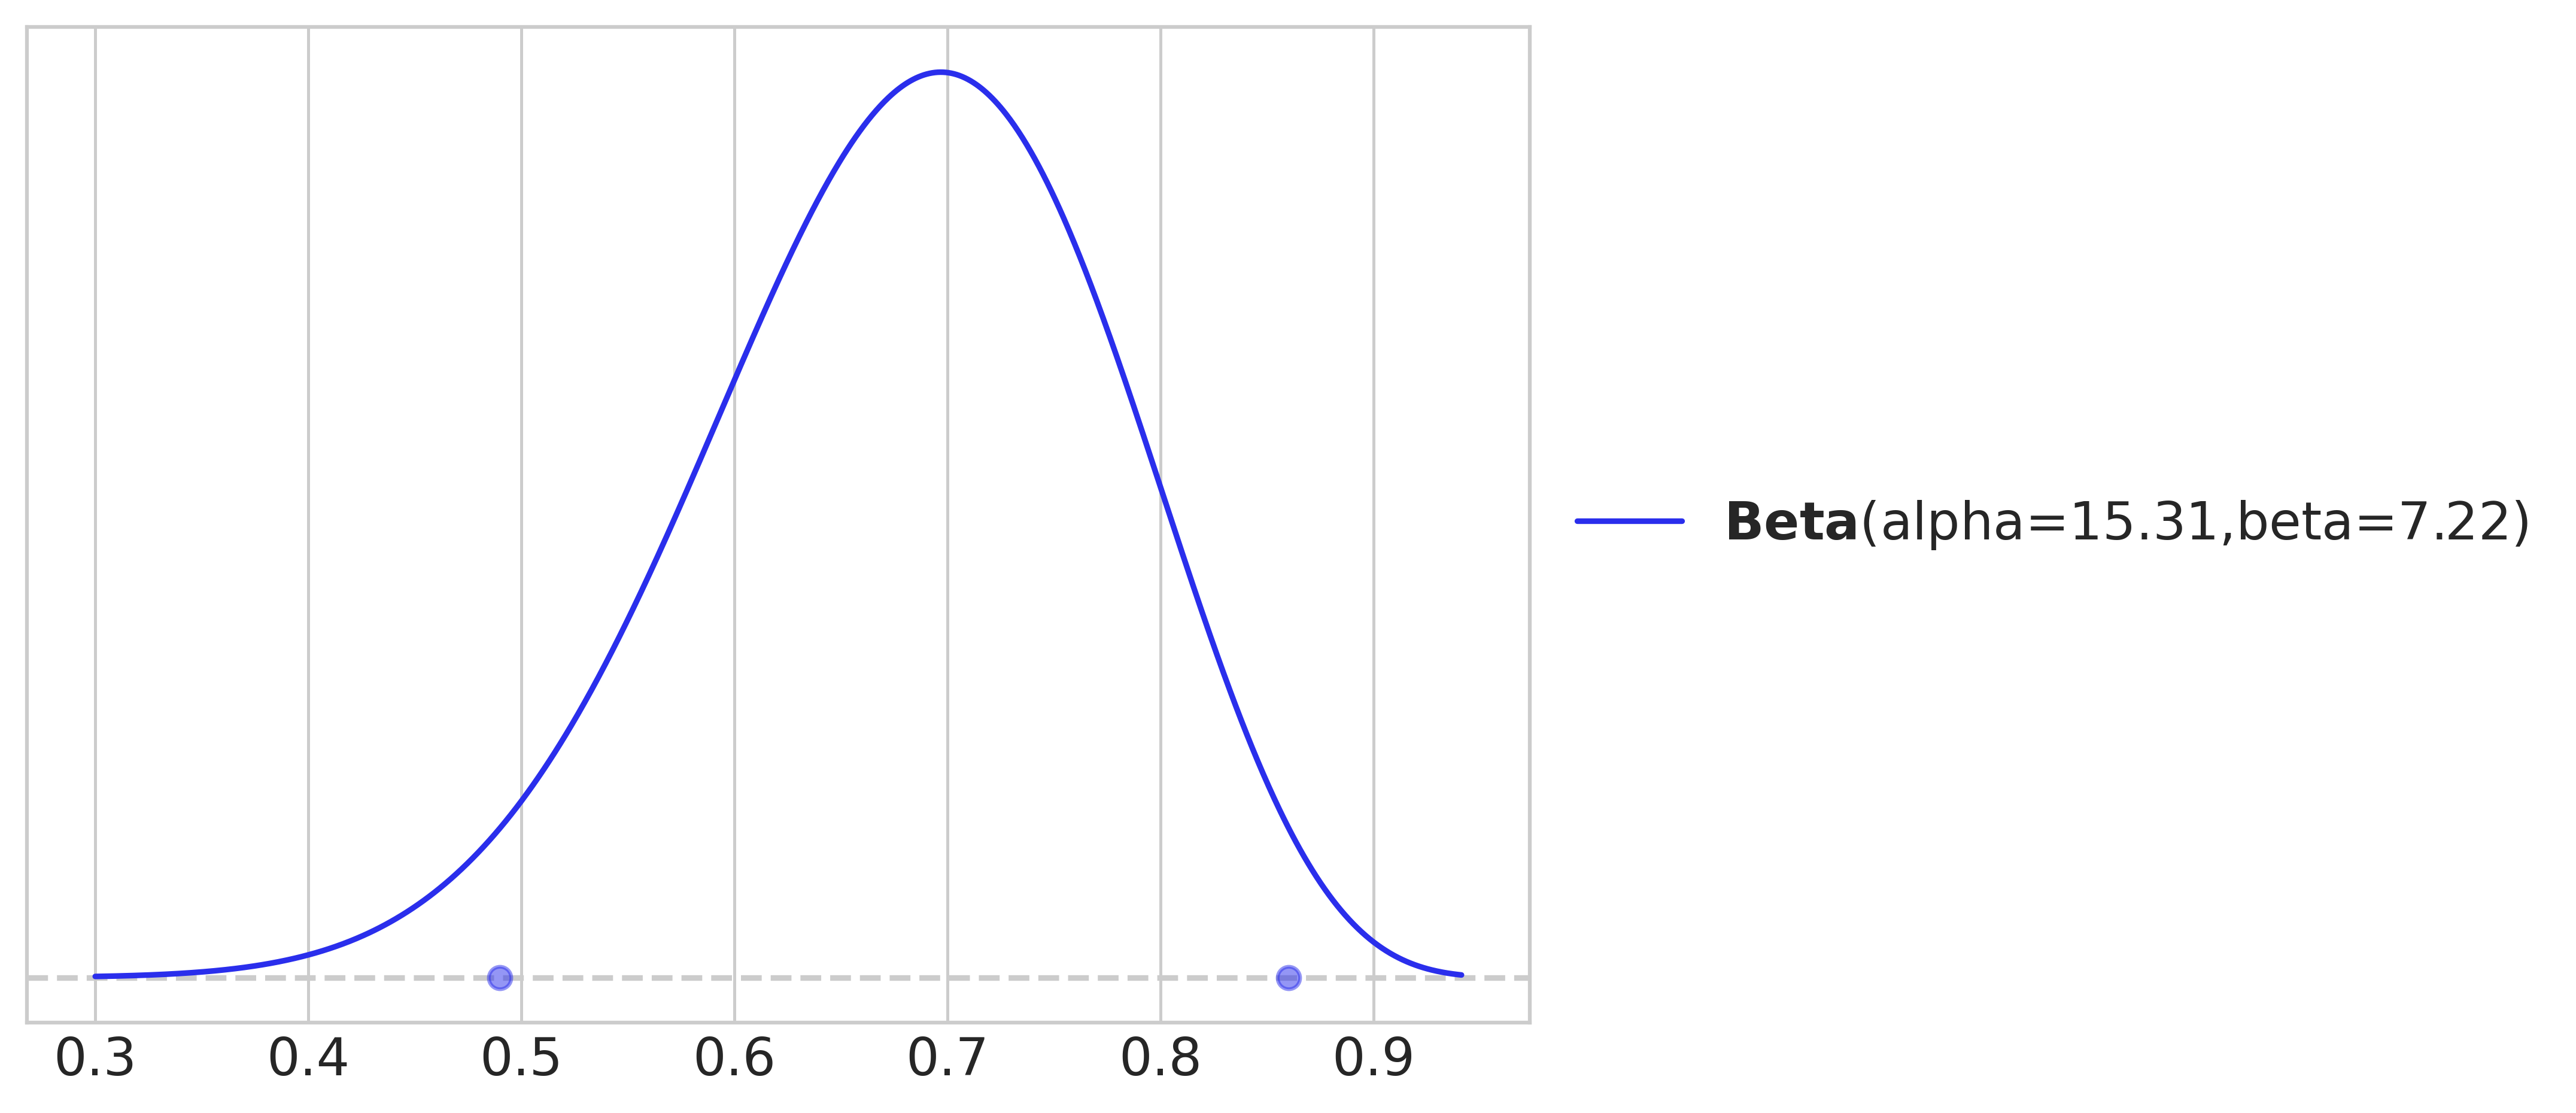

In [42]:
# Find Beta distribution parameters for mode = 0.7 and 95% HDI from 0.49 to 0.86
target_mode = 0.7
target_lower_bound = 0.49
target_upper_bound = 0.86

# Use Preliz to find the parameters
beta_dist = pz.Beta()
ax, beta_params = pz.maxent(beta_dist, mass=0.95, 
                        lower=target_lower_bound, upper=target_upper_bound, plot=True)

# Display the found parameters
print(f"Beta distribution parameters: alpha = {beta_params['x'][0]:.4f}, beta = {beta_params['x'][1]:.4f}")


C:\Users\User\AppData\Local\Temp\ipykernel_20288\1631795735.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


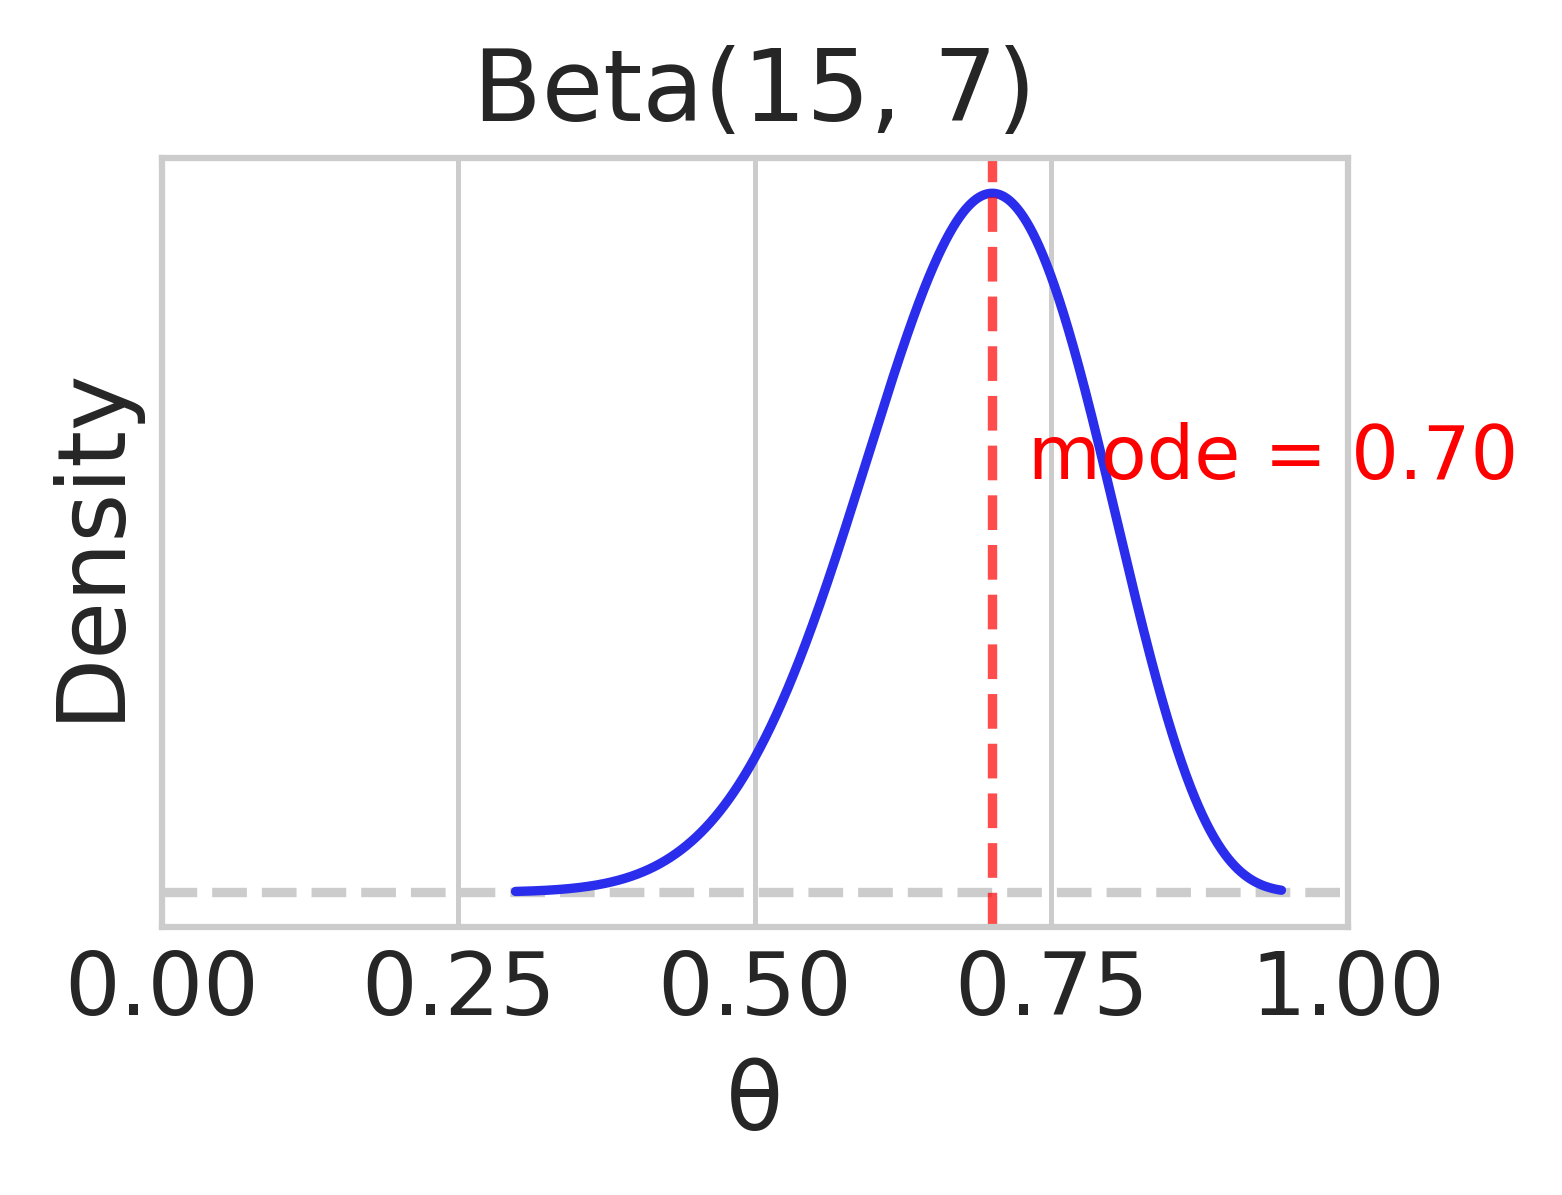

In [43]:
# Extract the parameters from beta_params
alpha = 15  # Approximately 15.31
beta = 7   # Approximately 7.22

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9/2.54, 7/2.54))

# Generate the Beta distribution plot with arviz
x = np.linspace(0, 1, 1000)
dist = pz.Beta(alpha=alpha, beta=beta)

dist.plot_pdf(ax=ax, legend=None)
# Calculate the actual mode of the Beta distribution
actual_mode = (alpha - 1) / (alpha + beta - 2)

# Add the mode to the plot
ax.axvline(actual_mode, linestyle='--', color='red', alpha=0.7)
ax.text(actual_mode + 0.03, 2.5, f"mode = {actual_mode:.2f}", 
    color='red', fontsize=12, va='center')

# Add labels and title
ax.set_xlabel('θ')
ax.set_ylabel('Density')
ax.set_title(f'Beta({alpha:.0f}, {beta:.0f})')

# Set limits and adjust layout
ax.set_xlim(0, 1.0)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])

plt.tight_layout()



C:\Users\User\AppData\Local\Temp\ipykernel_20288\3669010492.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


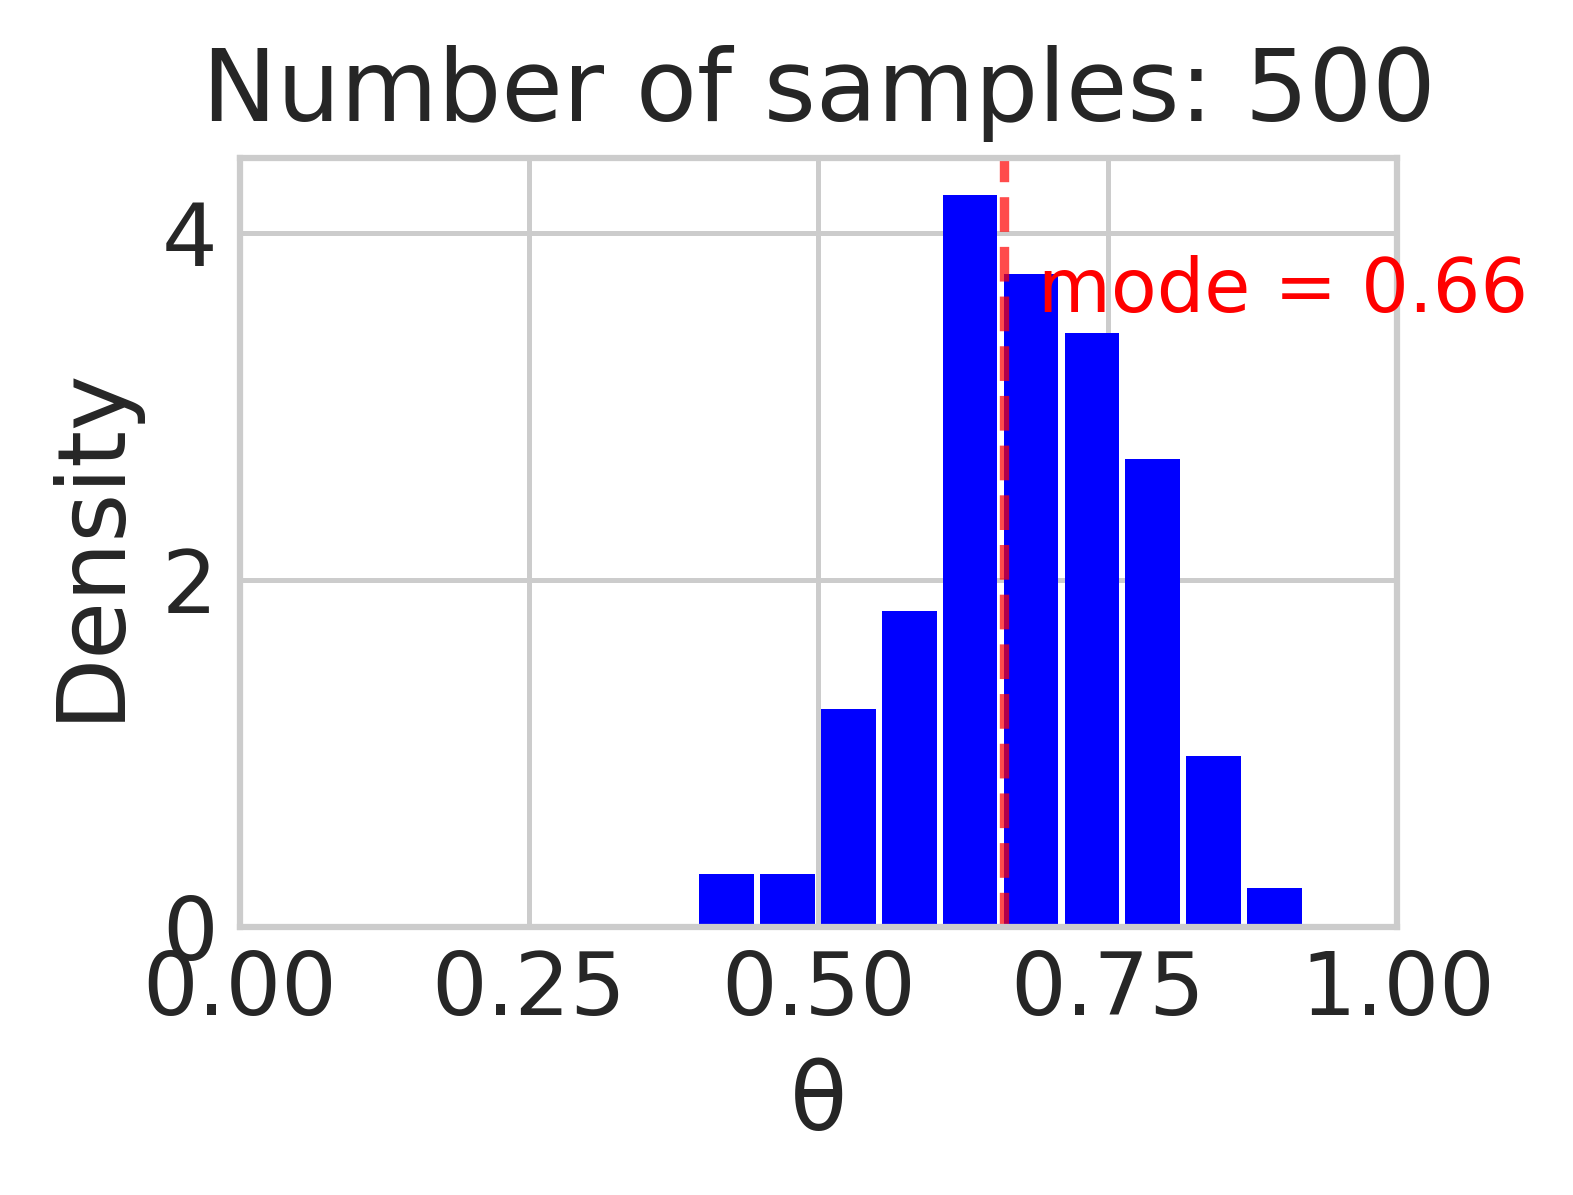

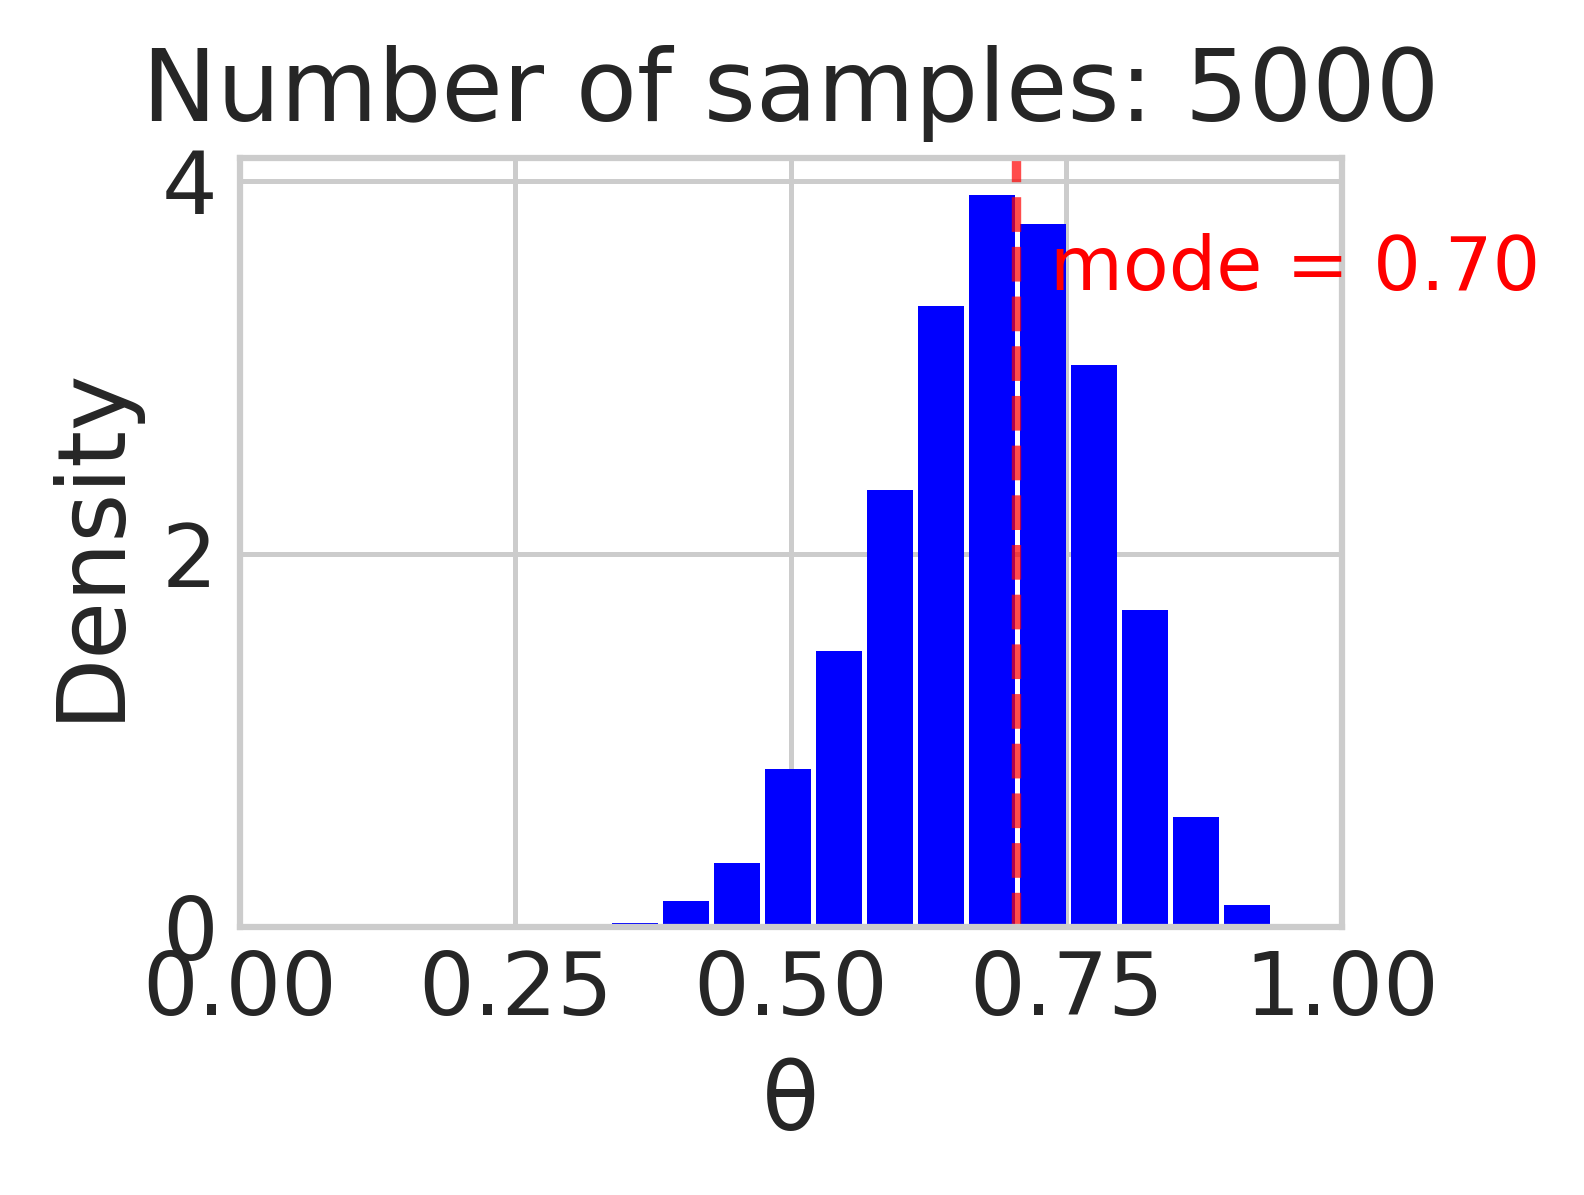

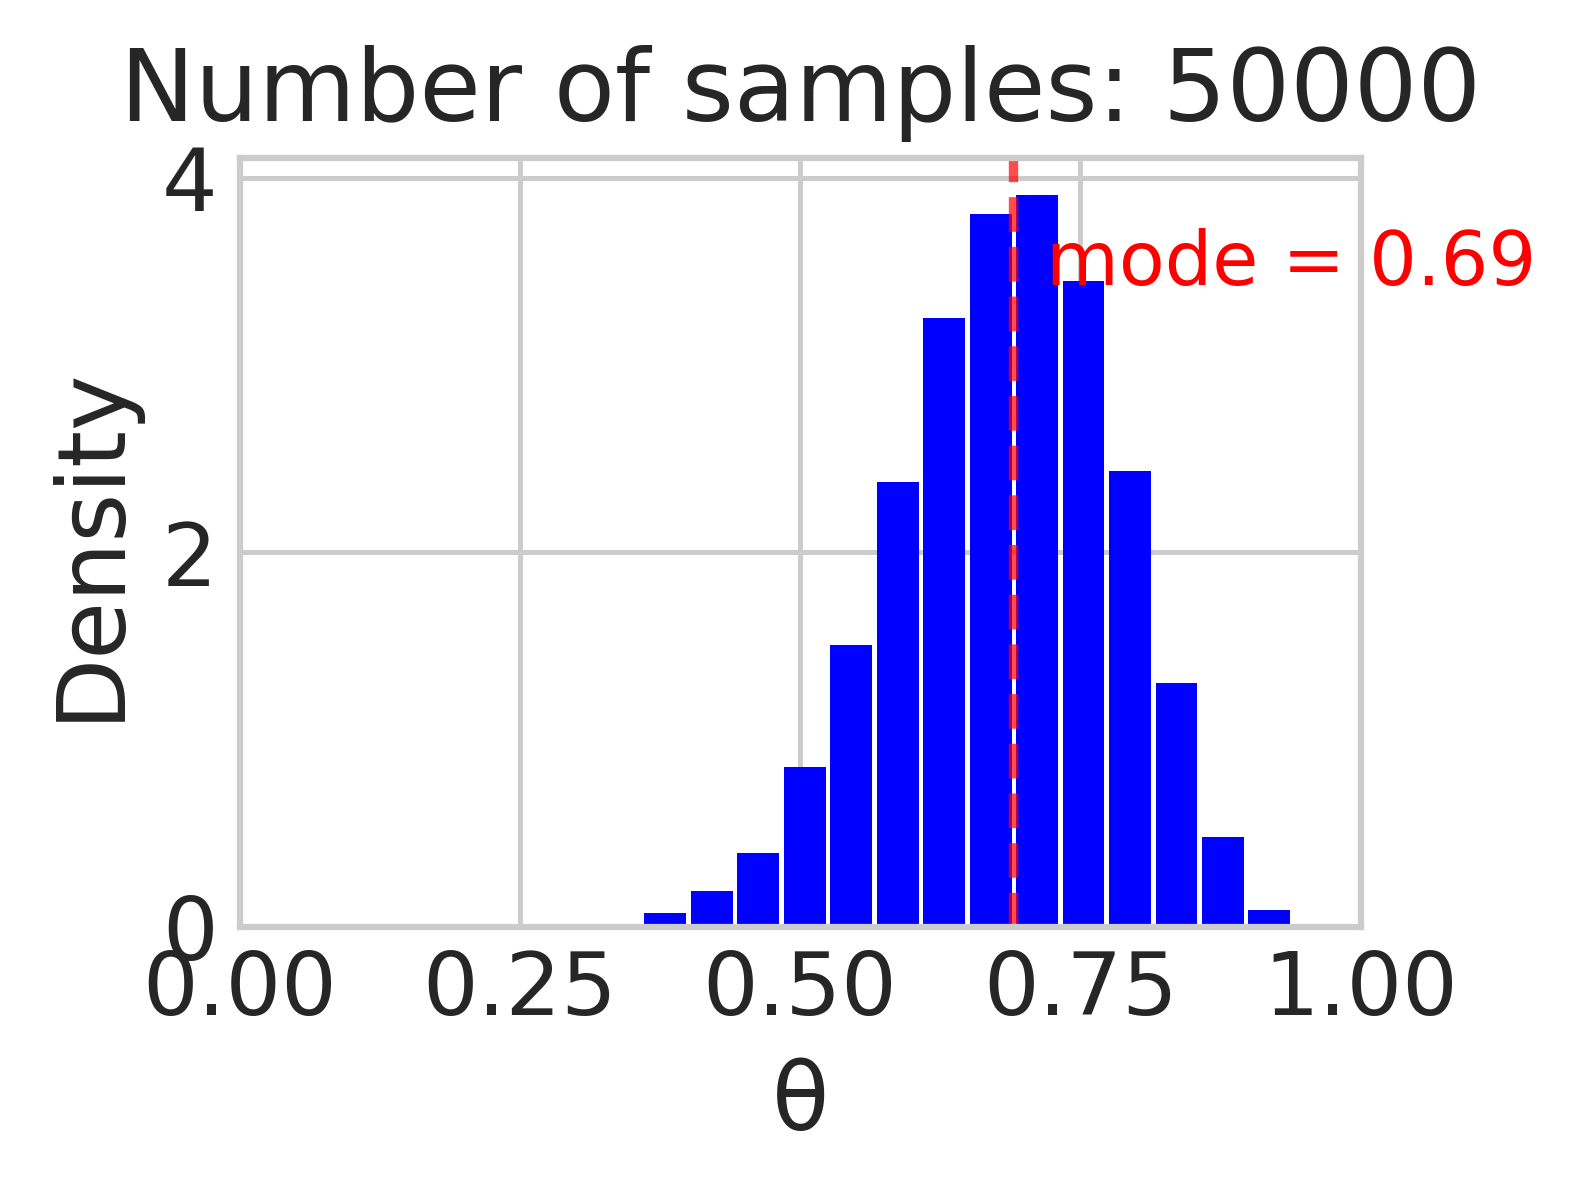

In [44]:
sample_sizes = [500, 5000, 50000]

for size in sample_sizes:
    # Sample from the Beta distribution
    samples = dist.rvs(size=size, random_state=123)

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(9/2.54, 7/2.54))

    # Plot histogram using ArviZ (with density normalization)
    az.plot_dist(samples, ax=ax, kind='hist', color='blue')

    # Estimate KDE to find the sample mode
    kde_x, kde_y = az.kde(samples)
    sample_mode = kde_x[np.argmax(kde_y)]

    # Add mode line and text
    ax.axvline(sample_mode, linestyle='--', color='red', alpha=0.7)
    ax.text(sample_mode + 0.03, max(kde_y)*0.9, f"mode = {sample_mode:.2f}", 
            color='red', fontsize=12, va='center')

    # Labels and limits
    ax.set_xlabel('θ')
    ax.set_ylabel('Density')
    ax.set_title(f'Number of samples: {size}')
    ax.set_xlim(0, 1.0)
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])

    # Layout
    plt.tight_layout()
    plt.show()



```stan
#include "./stan_example.stan"

In [45]:
N = 100
y = np.random.normal(0, 1, N)
mu_mu = 0
sd_mu = 1
sd_sd = 1

coords = {"data": np.arange(N)}
with pm.Model(coords=coords) as example_model:
    mu = pm.Normal("mu", mu=mu_mu, sigma=sd_mu)
    sd = pm.Normal("sd", mu=0, sigma=sd_sd)
    y = pm.Normal("y", mu=mu, sigma=sd, observed=y)

In [46]:
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = pz.Binomial(n=1, p=theta_real).rvs(trials)
data

array([0, 0, 1, 1])

In [47]:
with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=theta, observed=data)

In [48]:
idata = pm.sample(1000, model=our_first_model, random_seed=4591)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


In [49]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

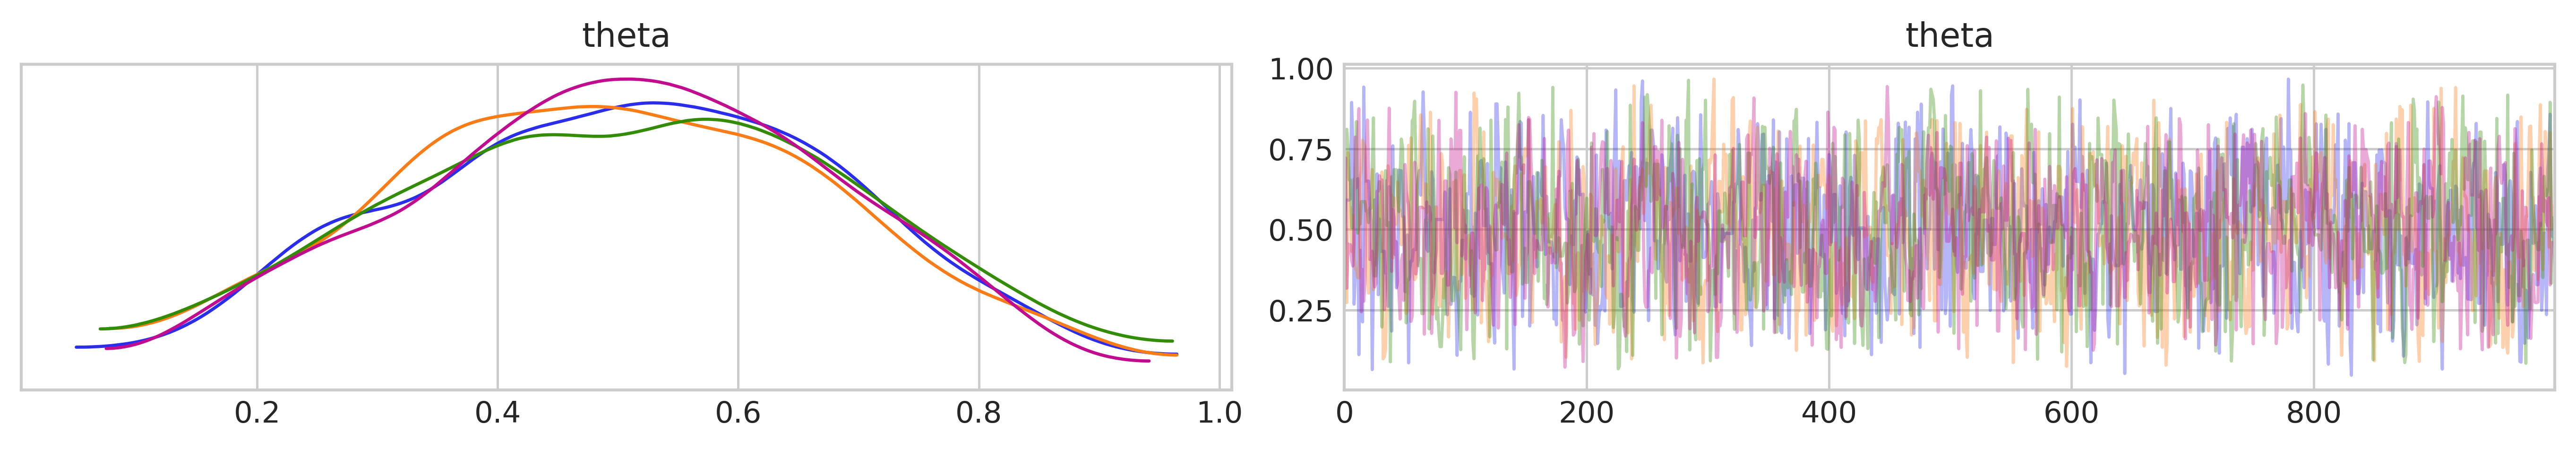

In [63]:
az.plot_trace(idata, chain_prop='color')

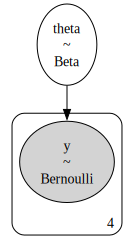

In [50]:
pm.model_to_graphviz(our_first_model)

In [51]:
our_first_model.basic_RVs

[theta ~ Beta(1, 1), y ~ Bernoulli(theta)]

In [52]:
pytensor.dprint(y)

bernoulli_rv{"()->()"}.1 [id A] 'y'
 ├─ RNG(<Generator(PCG64) at 0x216C500AB20>) [id B]
 ├─ [4] [id C]
 └─ ExpandDims{axis=0} [id D]
    └─ beta_rv{"(),()->()"}.1 [id E] 'theta'
       ├─ RNG(<Generator(PCG64) at 0x216C500A500>) [id F]
       ├─ NoneConst{None} [id G]
       ├─ 1.0 [id H]
       └─ 1.0 [id I]


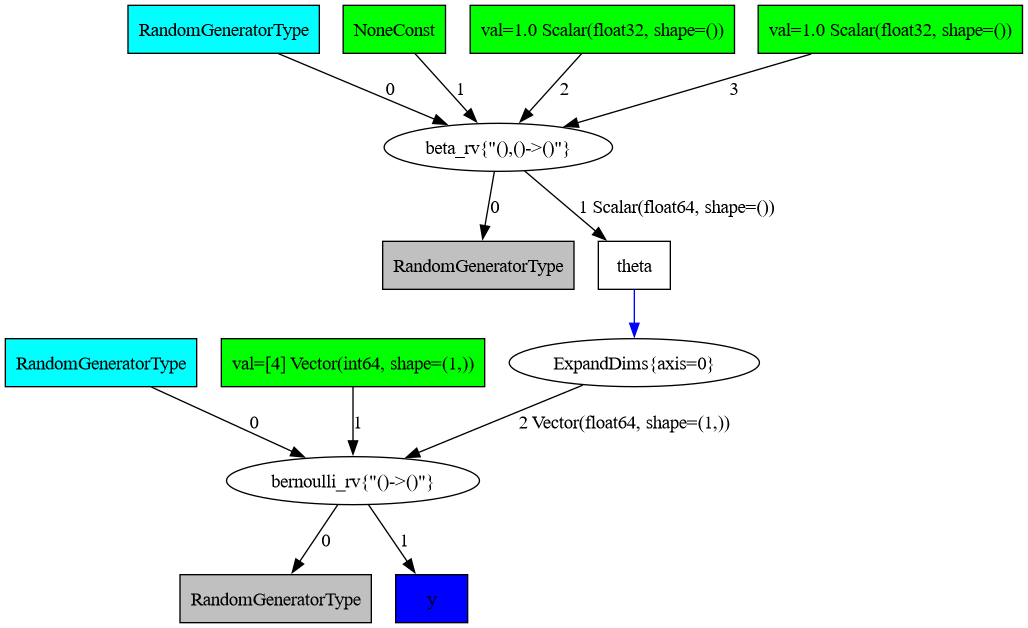

In [53]:
# Generate the graph image data without writing to disk
img_data = pydotprint(y, format="png", var_with_name_simple=True, return_image=True)

# Display the image in a Jupyter/Colab notebook
from IPython.display import Image, display
display(Image(img_data))

In [54]:
for i in range(10):
    print(f"Pytensor sample {i}: {theta.eval()}")

Pytensor sample 0: 0.2627429353138787
Pytensor sample 1: 0.2627429353138787
Pytensor sample 2: 0.2627429353138787
Pytensor sample 3: 0.2627429353138787
Pytensor sample 4: 0.2627429353138787
Pytensor sample 5: 0.2627429353138787
Pytensor sample 6: 0.2627429353138787
Pytensor sample 7: 0.2627429353138787
Pytensor sample 8: 0.2627429353138787
Pytensor sample 9: 0.2627429353138787


In [55]:
for i in range(10):
    print(f"Sample {i}: {pm.draw(theta)}")

Sample 0: 0.004255795023406815
Sample 1: 0.6698155650243434
Sample 2: 0.06065345239090157
Sample 3: 0.5133563126236904
Sample 4: 0.2587742797116704
Sample 5: 0.7665348088432179
Sample 6: 0.18533382006220156
Sample 7: 0.7243777252699158
Sample 8: 0.729156244061779
Sample 9: 0.0780931165047832


In [56]:
for i in range(10):
    random_theta, random_y = pm.draw([theta, y])
    print(f"Sample {i}: theta = {random_theta}, y = {random_y}")


Sample 0: theta = 0.36441637384821285, y = [1 0 1 1]
Sample 1: theta = 0.2870448610405863, y = [1 0 0 0]
Sample 2: theta = 0.6415360075628279, y = [1 1 1 1]
Sample 3: theta = 0.6759719633617202, y = [1 1 0 1]
Sample 4: theta = 0.8962846928591204, y = [1 1 1 1]
Sample 5: theta = 0.27114247086002824, y = [0 0 0 0]
Sample 6: theta = 0.48731380315345046, y = [1 1 0 0]
Sample 7: theta = 0.07054482863833741, y = [0 1 0 0]
Sample 8: theta = 0.3244129315582864, y = [0 0 1 0]
Sample 9: theta = 0.4111849417391461, y = [1 0 1 1]


In [57]:
from scipy import special 

sample_theta  = pm.draw(theta)    

logp_func = our_first_model.compile_logp()
joint_logp = logp_func({"theta_logodds__": special.logit(sample_theta)})

print("Sampled theta:", sample_theta)
print("Sampled y:", data)
print("Joint log probability:", joint_logp)

Sampled theta: 0.6961329442787405
Sampled y: [0 0 1 1]
Joint log probability: -4.660138844779684
